# Task 5: Model Training and Tracking
This notebook trains classification models on the proxy target, logs experiments with MLflow, and registers the best model.

In [15]:
# 1. Import Libraries (updated for classification + MLflow)
# -------------------------------------------------------------
import os
import sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import mlflow
import mlflow.sklearn
import mlflow.xgboost

# Ensure src imports available
ROOT = Path.cwd().resolve().parent
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))
from src.data_processing import calculate_rfm, create_proxy_target

In [16]:
# 2. Load the Raw Transactions Dataset
# -------------------------------------------------------------
from pathlib import Path
ROOT = Path.cwd().resolve().parent
raw_path = ROOT / "data" / "raw" / "data.csv"
df = pd.read_csv(raw_path)
df.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [17]:
# 3. Exploratory Data Analysis (EDA)
# -------------------------------------------------------------

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Summary statistics
print("\nSummary statistics:")
display(df.describe())


Missing values per column:
TransactionId           0
BatchId                 0
AccountId               0
SubscriptionId          0
CustomerId              0
CurrencyCode            0
CountryCode             0
ProviderId              0
ProductId               0
ProductCategory         0
ChannelId               0
Amount                  0
Value                   0
TransactionStartTime    0
PricingStrategy         0
FraudResult             0
dtype: int64

Summary statistics:


,CountryCode,Amount,Value,PricingStrategy,FraudResult
count,95662.0,9.566200e+04,9.566200e+04,95662.000000,95662.000000
mean,256.0,6.717846e+03,9.900584e+03,2.255974,0.002018
std,0.0,1.233068e+05,1.231221e+05,0.732924,0.044872
min,256.0,-1.000000e+06,2.000000e+00,0.000000,0.000000
25%,256.0,-5.000000e+01,2.750000e+02,2.000000,0.000000
50%,256.0,1.000000e+03,1.000000e+03,2.000000,0.000000
75%,256.0,2.800000e+03,5.000000e+03,2.000000,0.000000
max,256.0,9.880000e+06,9.880000e+06,4.000000,1.000000


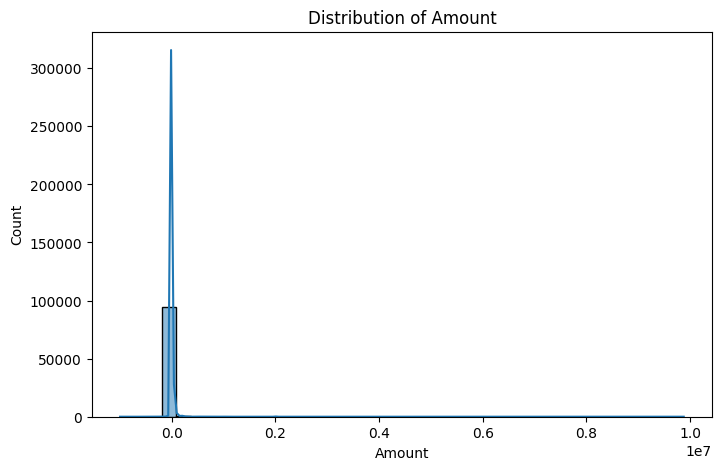

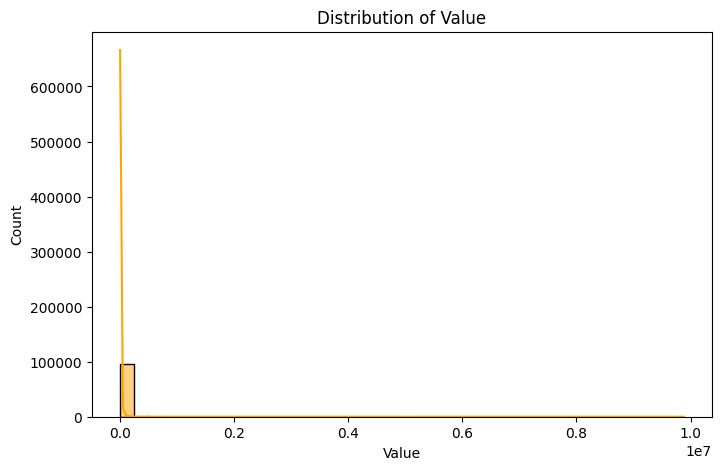

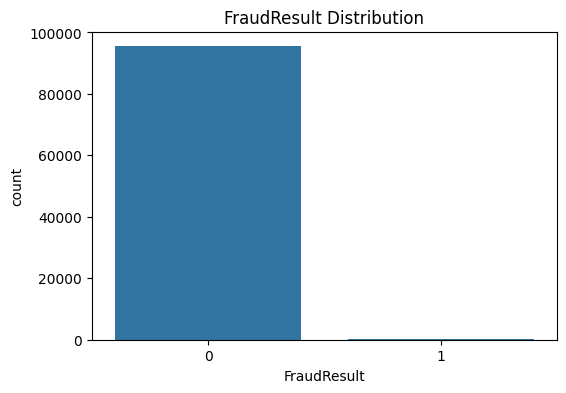

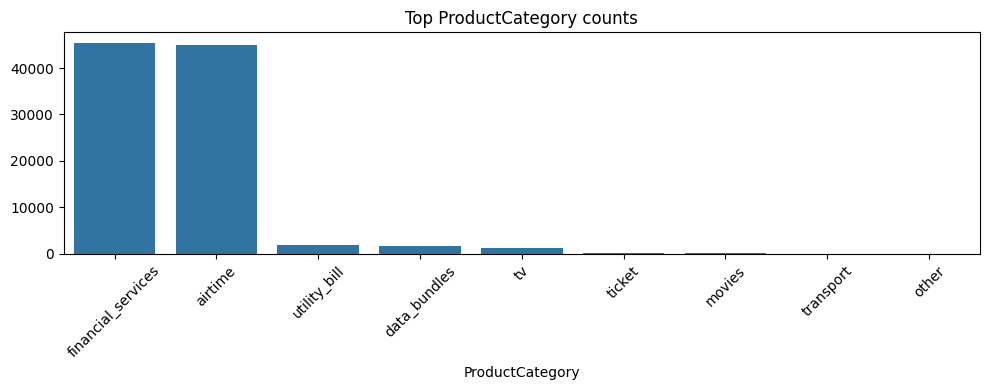

In [18]:
# Basic distributions and categorical summaries for our dataset
# -------------------------------------------------------------
plt.figure(figsize=(8,5))
sns.histplot(df['Amount'], bins=40, kde=True)
plt.title('Distribution of Amount')
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(df['Value'], bins=40, kde=True, color='orange')
plt.title('Distribution of Value')
plt.show()

# FraudResult (binary) distribution if present
if 'FraudResult' in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x='FraudResult', data=df)
    plt.title('FraudResult Distribution')
    plt.show()

# Top categories by frequency
if 'ProductCategory' in df.columns:
    top_cats = df['ProductCategory'].value_counts().head(10)
    plt.figure(figsize=(10,4))
    sns.barplot(x=top_cats.index, y=top_cats.values)
    plt.xticks(rotation=45)
    plt.title('Top ProductCategory counts')
    plt.tight_layout()
    plt.show()

In [19]:
# Deprecated (insurance regression). See Section 3 for classification target.
pass

In [20]:
# Deprecated (insurance regression feature lists). Not used.
pass

In [24]:
# - Numerical features are scaled for regression (mean=0, std=1)
# - Categorical features are one-hot encoded (drop first to avoid multicollinearity)
# - Preprocessing ensures data is ready for model training

In [21]:
# Deprecated duplicate (insurance regression feature lists). Not used.
pass

In [ ]:
# Deprecated regression preprocessor. Classification uses RFM or processed features below.
pass

In [27]:
# - Split dataset into training (80%) and testing (20%)
# - Ensures we evaluate model on unseen data

In [22]:
# 5. Train-Test Split
# -------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Pipeline([...])- Chains preprocessing and model together so GridSearch can handle everything automatically.

In [24]:
# 2. MLflow Setup
# -------------------------------------------------------------
tracking_uri = os.environ.get("MLFLOW_TRACKING_URI", "file:./mlruns")
mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment("credit_risk_proxy_model")
print("MLflow tracking URI:", tracking_uri)

MLflow tracking URI: file:./mlruns


In [25]:
# 3. Load Processed Data or Fallback to RFM
# -------------------------------------------------------------
processed_path = ROOT / "data" / "processed" / "customer_features_with_target.csv"
raw_path = ROOT / "data" / "raw" / "data.csv"

if processed_path.exists():
    df = pd.read_csv(processed_path)
    assert "is_high_risk" in df.columns, "Processed dataset must include 'is_high_risk' target"
    X = df.drop(columns=["CustomerId", "is_high_risk"])
    y = df["is_high_risk"].astype(int)
    print("Loaded processed dataset:", processed_path)
else:
    print("Processed dataset not found; falling back to RFM from raw.")
    df_raw = pd.read_csv(raw_path)
    rfm = calculate_rfm(df_raw)
    proxy = create_proxy_target(rfm, n_clusters=3, random_state=42, plot=False)
    # Use RFM numeric features as X
    features = ["Recency", "Frequency", "Monetary", "Monetary_abs", "Monetary_positive"]
    X = proxy[features].copy()
    y = proxy["is_high_risk"].astype(int)

print("X shape:", X.shape, "y distribution:", y.value_counts(normalize=True))

Processed dataset not found; falling back to RFM from raw.
Cluster Summary (mean values):
           Recency  Frequency_log  Monetary_abs_log
cluster                                            
1        60.863333       1.227759          8.455147
0        21.858311       1.935131         10.153124
2        11.735568       3.828521         12.202124
Selected high-risk cluster: 1
Proxy target distribution (%):
is_high_risk
0    67.93
1    32.07
Name: proportion, dtype: float64
X shape: (3742, 5) y distribution: is_high_risk
0    0.679316
1    0.320684
Name: proportion, dtype: float64


In [26]:
# 4. Train/Validation Split
# -------------------------------------------------------------
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (2993, 5) Test size: (749, 5)


In [6]:
# 5. Metrics Helper
# -------------------------------------------------------------
def evaluate_model(y_true, y_pred, y_proba=None):
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
    }
    if y_proba is not None:
        metrics["roc_auc"] = roc_auc_score(y_true, y_proba)
    return metrics

2025/12/16 17:46:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


({'accuracy': 0.897196261682243,
  'precision': 0.7985347985347986,
  'recall': 0.9083333333333333,
  'f1': 0.8499025341130604,
  'roc_auc': 0.9678945645055665},
 'runs:/940294264eac4dd89c915fda87f4ea36/model')

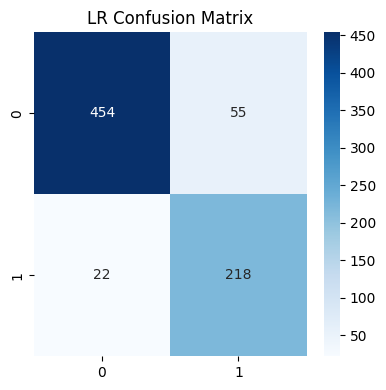

In [12]:
# 6. Train + Log: Logistic Regression (fast grid)
# -------------------------------------------------------------
from sklearn.pipeline import Pipeline
lr_params = {
    'C': [0.1, 1],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'class_weight': ['balanced']
}

scaler = StandardScaler()
lr = LogisticRegression(max_iter=500, random_state=42)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

with mlflow.start_run(run_name="LogisticRegression"):
    X_tr = scaler.fit_transform(X_train)
    grid = GridSearchCV(lr, lr_params, cv=cv, scoring='roc_auc', n_jobs=1)
    grid.fit(X_tr, y_train)
    best_lr = grid.best_estimator_
    X_te = scaler.transform(X_test)
    y_pred_lr = best_lr.predict(X_te)
    y_proba_lr = best_lr.predict_proba(X_te)[:, 1]
    metrics_lr = evaluate_model(y_test, y_pred_lr, y_proba_lr)
    mlflow.log_params(grid.best_params_)
    mlflow.log_metrics(metrics_lr)
    mlflow.sklearn.log_model(best_lr, "model")
    report = classification_report(y_test, y_pred_lr, output_dict=True)
    mlflow.log_dict(report, "classification_report_lr.json")
    cm = confusion_matrix(y_test, y_pred_lr)
    fig, ax = plt.subplots(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title('LR Confusion Matrix')
    plt.tight_layout()
    fig_path = "lr_confusion_matrix.png"
    plt.savefig(fig_path)
    mlflow.log_artifact(fig_path)
    os.remove(fig_path)
    lr_run_id = mlflow.active_run().info.run_id
    lr_model_uri = f"runs:/{lr_run_id}/model"
metrics_lr, lr_model_uri

2025/12/16 17:48:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


({'accuracy': 0.9893190921228304,
  'precision': 0.9957264957264957,
  'recall': 0.9708333333333333,
  'f1': 0.9831223628691983,
  'roc_auc': 0.9995743287491813},
 'runs:/264c04e7d3fd47cbb03e74962d414c96/model')

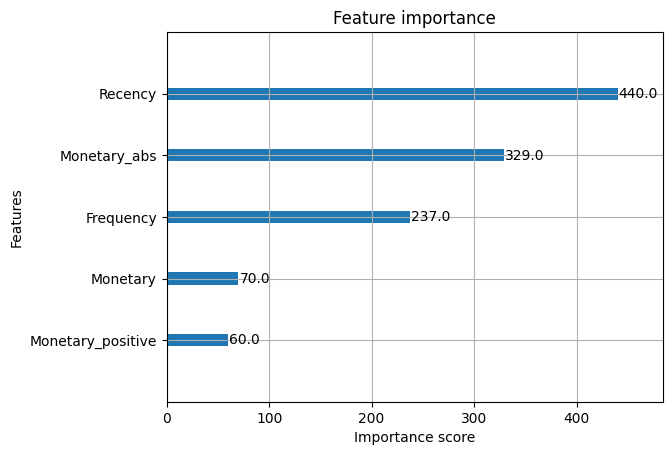

In [13]:
# 7. Train + Log: XGBoost
# -------------------------------------------------------------
import xgboost as xgb
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1, (y_train == 0).sum() / max((y_train == 1).sum(), 1)]
}

xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='auc')

with mlflow.start_run(run_name="XGBoost"):
    grid_xgb = GridSearchCV(xgb_model, xgb_params, cv=3, scoring='roc_auc', n_jobs=-1)
    grid_xgb.fit(X_train, y_train)
    best_xgb = grid_xgb.best_estimator_
    y_pred_xgb = best_xgb.predict(X_test)
    y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]
    metrics_xgb = evaluate_model(y_test, y_pred_xgb, y_proba_xgb)
    mlflow.log_params(grid_xgb.best_params_)
    mlflow.log_metrics(metrics_xgb)
    mlflow.xgboost.log_model(best_xgb, "model")
    fig_imp = xgb.plot_importance(best_xgb, max_num_features=10)
    fig_path_imp = "xgb_feature_importance.png"
    plt.savefig(fig_path_imp)
    mlflow.log_artifact(fig_path_imp)
    os.remove(fig_path_imp)
    xgb_run_id = mlflow.active_run().info.run_id
    xgb_model_uri = f"runs:/{xgb_run_id}/model"
metrics_xgb, xgb_model_uri

In [14]:
# 8. Select and Register Best Model
# -------------------------------------------------------------
best_name = "XGBoost" if metrics_xgb.get("roc_auc", 0) > metrics_lr.get("roc_auc", 0) else "LogisticRegression"
best_uri = xgb_model_uri if best_name == "XGBoost" else lr_model_uri
print("Best by ROC-AUC:", best_name)
print("Model URI:", best_uri)

# Attempt to register (requires server-backed tracking URI)
try:
    registered = mlflow.register_model(best_uri, "CreditRiskProxyModel")
    print("Registered version:", registered.version)
except Exception as e:
    print("Model registration skipped or failed:", e)

C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\mlflow\tracking\_model_registry\utils.py:215: FutureWarning: The filesystem model registry backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance.
  return FileStore(store_uri)
Successfully registered model 'CreditRiskProxyModel'.
2025/12/16 17:49:04 WARNING mlflow.tracking._model_registry.fluent: Run with id 264c04e7d3fd47cbb03e74962d414c96 has no artifacts at artifact path 'model', registering model based on models:/m-a5395208759d4daabc2006b5149354e0 instead


Best by ROC-AUC: XGBoost
Model URI: runs:/264c04e7d3fd47cbb03e74962d414c96/model
Registered version: 1


Created version '1' of model 'CreditRiskProxyModel'.
